# The Orienteering Problem

## Risoluzione tramite algoritmo genetico

### Valerio Domenico Conte M63001606

## Import delle librerie

In [204]:
import random
import math
import time

from deap import base, creator, tools, algorithms

import matplotlib.pyplot as plt

## Lettura dei dati dell'istanza

In [205]:
#path = "op_tmax_60.txt"
path = "set_66_1_120.txt"

file = open(path, "r")

rules = file.readline().split("\t")

# Tmax è il limite sulla durata/lunghezza del percorso
# S è il numero di soluzioni di percorsi da fornire come soluzione
Tmax = int(rules[0])
P = int(rules[1])

# Position è una lista di tuple per memorizzare le coordinate dei nodi
# S è una lista di interi per memorizzare i punteggi associati a ciscun nodo
positions = []
S = []

for line in file:
    x, y, score = line.split("\t")
    positions.append((float(x), float(y)))
    S.append(int(score))
    
file.close()

# Il secondo nodo nella lista è da considerare come nodo destinazione
# Spostiamo le sue coordinate in ultima posizione di positions e il suo punteggio in ultima posizione di S
last_node = positions.pop(1)
positions.append(last_node)

last_score = S.pop(1)
S.append(last_score)

# Funzione per calcolare la distanza euclidea tra i punti e ottenere la matrice delle distanze
def getDistanceMatrix(positions):
    distance_matrix = []
    
    for item1 in positions:
        tmp_list = []
        for item2 in positions:
            tmp_distance = math.sqrt((item1[0]-item2[0])**2+(item1[1]-item2[1])**2)     
            tmp_list.append(tmp_distance)
        distance_matrix.append(tmp_list)
    return distance_matrix

# Matrice ddelle distanze tra i nodi
distance_map = getDistanceMatrix(positions)

## Creazione di individui e popolazione

In [206]:
# Il numero di geni degli individui è pari al numero di nodi meno 2
IND_SIZE = len(S) - 2

# Il primo e l'ultimo nodo sono fissi per questo li sottraiamo dal numero di geni
# Memorizziamo le loro posizioni per poterli usare nel calcolo delle distanze in seguito
start_node = 0
end_node = len(S) - 1

# Creazione delle classi di fitness e individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Creazione del toolbox per la definizione degli operatori evolutivi
toolbox = base.Toolbox()

# Registrazione delle funzioni per la generazione di geni, individui e popolazioni
toolbox.register("indices", random.sample, range(IND_SIZE), IND_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Valutazione della funzione di fitness

In [207]:
# Funzione di fitness evaluation per gli individui
def evalOP(individual):
    # Costruzione del percorso
    path = [start_node] + [i + 1 for i in individual] + [end_node]
    
    # Inizializzazione delle variabili per il calcolo della distanza e del punteggio
    distance = 0
    score = 0

    # Calcolo della distanza e del punteggio su ogni coppia di geni adiacenti nel percorso
    for gene1, gene2 in zip(path[:-1], path[1:]):
        d_ij = distance_map[gene1][gene2]
        
        distance += d_ij
        
        # Veirfica che il percorso corrente non superi la durata massima
        if distance > Tmax:
            return 0,

        score += S[gene2]
        
        # Prelevo le righe della matrice delle distanze relative ai due geni
        gen1_row = distance_map[gene1]
        gen2_row = distance_map[gene2]
        
        # Verifico se ci sono punti collineari con i due geni
        # In caso positivo, penalizza il percorso decremntendo il punteggio
        for i in range(len(S)):
            if (i != gene1) and (i != gene2):
                if gen1_row[i] + gen2_row[i] == d_ij:
                    score -= 5

    return score,

# Registrazione della funzione di fitness evaluation nel toolbox
toolbox.register("evaluate", evalOP)

## Operatori genetici e di selezione

In [208]:
# Funzione di crossover (accoppiamento/riproduzione)
def cxVariableLen(ind1, ind2):
    size1 = len(ind1)
    size2 = len(ind2)
    
    # Calcola la dimensione minore tra i due genitori per evitare errori di indicizzazione
    min_size = min(size1, size2)
    
    # Punto di crossover casuale nel range della dimensione minore
    cxpoint = random.randint(0, min_size - 1)

    # Scambia i geni tra i due genitori con crossover single point nel punto calcolato
    child1_genes = ind1[:cxpoint] + ind2[cxpoint:]
    child2_genes = ind2[:cxpoint] + ind1[cxpoint:]
    
    # Assicuriamoci che i figli siano sequenze di nodi unici
    child1_genes = fix_child(child1_genes)
    child2_genes = fix_child(child2_genes)
    
    # Istanzia nuovi individui con i geni corretti
    child1 = creator.Individual(child1_genes)
    child2 = creator.Individual(child2_genes)
    
    # Aggiorna gli individui originali con i loro figli
    ind1[:] = child1
    ind2[:] = child2
    
    return ind1, ind2

# Metodo ausiliario per la correzione degli individui figli
def fix_child(child_genes):
    seen = set()
    
    # Nuova lista di geni senza duplicati e che preserva l'ordine di prima apparizione dei geni
    fixed_child_genes = [x for x in child_genes if not (x in seen or seen.add(x))]
    
    return fixed_child_genes

# Funzione di mutazione
def mutVariableLen(individual, prob_pop, prob_swap):
    if random.random() < prob_pop:
        if len(individual) > 1:
            # Rimozione di un gene in una posizione casuale
            random_index = random.randint(0, len(individual) - 1)
            individual.pop(random_index)
            
            # Rimozione del gene finale
            #individual.pop()
    else:
        if len(individual) < IND_SIZE:
            # Aggiunta di un nuovo gene in una posizione casuale
            new_node = random.randint(0, IND_SIZE - 1)
            random_index = random.randint(0, len(individual) - 1)
        
            if new_node not in individual:
                individual.insert(random_index, new_node)
                
                # Aggiunta del gene alla fine della lista
                #individual.append(new_node)
                            
            
    if random.random() < prob_swap:    
        # Swap di due geni scelti casualmente
        if len(individual) > 1:
            index1, index2 = random.sample(range(len(individual)), 2)
            individual[index1], individual[index2] = individual[index2], individual[index1]
        
    return individual,

# Probabilità di eliminazione e di scambio dei geni
prob_pop = 0.45
prob_swap = 0.4

# Registrazione degli operatori evolutivi (genetici e di selezione) nel toolbox
toolbox.register("mate", cxVariableLen)
toolbox.register("mutate", mutVariableLen, prob_pop=prob_pop, prob_swap=prob_swap)
toolbox.register("select", tools.selTournament, tournsize=3)

## Esecuzione dell'algoritmo

In [209]:
random.seed(Tmax)

start_time = time.time()

# Parametri per l'algoritmo:
#   npop = numero di individui nella popolazione
#   ngen = numero di generazioni
#   cxpb = probabilità di crossover
#   mutpb = probabilità di mutazione
npop = 50

if (path == "op_tmax_60.txt"):
    # Parametri per I1
    ngen = 2500
    cxpb = 0.75
else:
    # Parametri per I2
    ngen = 4500
    cxpb = 0.8

mutpb = 0.05

# Generazione della popolazione iniziale
population = toolbox.population(n=npop)

# Esecuzione dell'algoritmo genetico. In output:
#   final_population = popolazione finale
#   logbook = statistiche delle generazioni
final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=False)

end_time = time.time()

# Estrazione della migliore soluzione nella popolazione finale
best_ind = tools.selBest(final_population, 1)[0]

# Visualizzazione del valore di fitness migliore e del tempo di calcolo
print(f"Fitness migliore: {best_ind.fitness.values[0]}")
print(f"Tempo di calcolo: {end_time - start_time}")

# Costruzione e visualizzazione della soluzione finale
final_solution = []
final_solution.append(start_node)

for i in range(len(best_ind)):
    final_solution.append(best_ind[i] + 1)

final_solution.append(end_node)

print(f"Soluzione migliore: {final_solution}")

Fitness migliore: 950.0
Tempo di calcolo: 15.492523908615112
Soluzione migliore: [0, 49, 41, 34, 27, 5, 4, 13, 7, 14, 6, 16, 15, 23, 32, 24, 31, 30, 57, 58, 51, 42, 33, 25, 26, 35, 52, 61, 62, 63, 46, 45, 53, 44, 50, 65]


## Visualizzazione del percorso

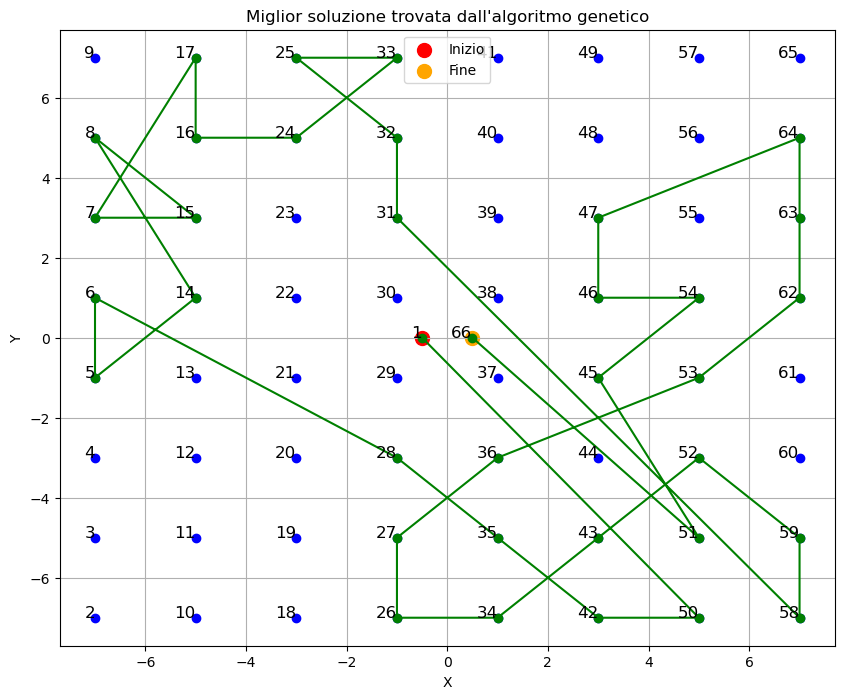

In [210]:
%matplotlib inline

# Metodo per plottare i punti del grafo e un percorso che li attraversa
def plot_path(node_positions, path):
    # Estrazione delle coordinate dei nodi nel percorso
    x = [node_positions[i][0] for i in path]
    y = [node_positions[i][1] for i in path]

    plt.figure(figsize=(10, 8))
    plt.scatter(*zip(*node_positions), c='blue')
    
    # Etichettamento dei nodi
    for idx, (x_pos, y_pos) in enumerate(node_positions):
        plt.text(x_pos, y_pos, str(idx+1), fontsize=12, ha='right')
    
    # Plot del percorso
    plt.plot(x, y, linestyle='-', marker='o', color='green')

    # Evidenza inizio e fine del percorso
    plt.scatter(node_positions[path[0]][0], node_positions[path[0]][1], c='red', s=100, label='Inizio')
    plt.scatter(node_positions[path[-1]][0], node_positions[path[-1]][1], c='orange', s=100, label='Fine')
    
    # Mostra titolo, assi, leggenda, griglia e percorso
    plt.title("Miglior soluzione trovata dall'algoritmo genetico")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    plt.show()

# Eseguire la funzione per plottare il percorso migliore trovato
plot_path(positions, final_solution)